# Introduction

Judul project: Time Series Forecasting AirPassengers Dataset

deskripsi:

Dataset AirPassengers (1949–1960)

Tujuan: Forecast jumlah penumpang 24 bulan ke depan

Metode: ARIMA & SARIMA

# Import libraries

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller  # untuk uji stationarity
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # untuk lihat ACF & PACF
from statsmodels.tsa.arima.model import ARIMA  # untuk membangun model ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load Dataset

## Baca Dataset

In [2]:
# Dataset bulanan penumpang pesawat (1949-1960)
from statsmodels.datasets import get_rdataset

data = get_rdataset("AirPassengers")  # dataset bawaan R
df = data.data

In [4]:
df.head()

,time,value
0,1949.000000,112
1,1949.083333,118
2,1949.166667,132
3,1949.250000,129
4,1949.333333,121


## Change Month to datetime

In [5]:
# Rename kolom biar enak dibaca
df.columns = ["Month", "Passengers"]
df["Month"] = pd.to_datetime(df["Month"])
df.set_index("Month", inplace=True)

print(df.head())

                               Passengers
Month                                    
1970-01-01 00:00:00.000001949         112
1970-01-01 00:00:00.000001949         118
1970-01-01 00:00:00.000001949         132
1970-01-01 00:00:00.000001949         129
1970-01-01 00:00:00.000001949         121


## Save to csv

In [6]:
df.to_csv('AirPassengers.csv')

## Set index to Month

In [7]:
df = df.copy()

# buat index bulanan mulai jan 1949, panjangnya = jumlah baris df
df.index = pd.date_range(start="1949-01-01", periods = len(df), freq = "M")

# set index jadi Month
df.index.name = "Month"

df.head()

,Passengers
Month,
1949-01-31,112
1949-02-28,118
1949-03-31,132
1949-04-30,129
1949-05-31,121


# Visualiasi Awal

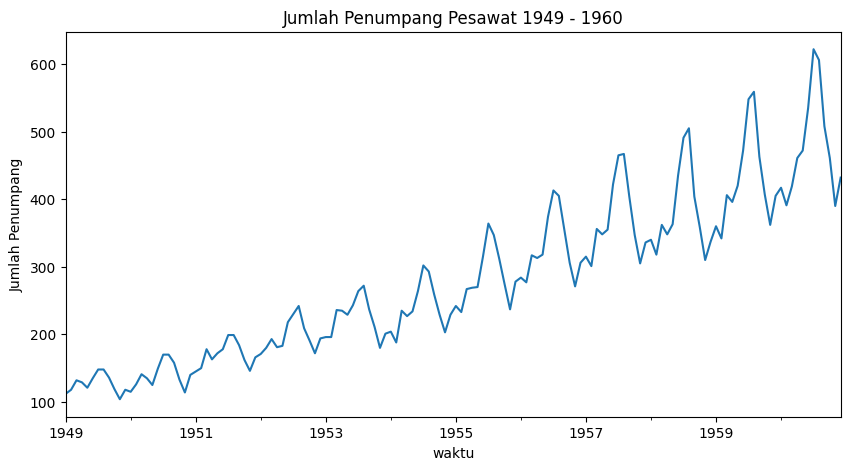

In [8]:
df["Passengers"].plot(figsize = (10,5), title = "Jumlah Penumpang Pesawat 1949 - 1960")
plt.ylabel("Jumlah Penumpang")
plt.xlabel("waktu")
plt.show()

# Uji stationarity (ADF Test)

In [9]:
result = adfuller(df["Passengers"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4]["5%"])

ADF Statistic: 0.8153688792060463
p-value: 0.991880243437641
Critical Values: -2.8840418343195267


- H0 diterima hasil p-value lebih dari 0.05 yaitu 0.9918 yang berarti data tersebut non-stasioner.
- sesuai dengan hasil grafik yang dihasilkan ada pola trend naik dan juga seasonality.
- langkah selanjutnya kita akan melakukan differencing 1 kali d=1, bila data masih non-stasioner maka kita akan melakukan differencing lagi d=2.

In [10]:
result

(np.float64(0.8153688792060463),
 np.float64(0.991880243437641),
 13,
 130,
 {'1%': np.float64(-3.4816817173418295),
  '5%': np.float64(-2.8840418343195267),
  '10%': np.float64(-2.578770059171598)},
 np.float64(996.692930839019))

# Differencing 1


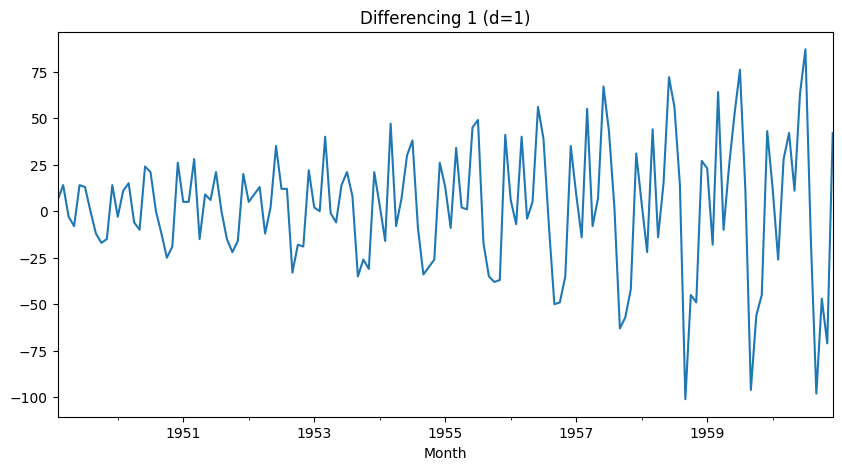

ADF Statistic (d=1) -2.8292668241699923
p-value (d=1) 0.054213290283826474
Critical Values (d=1) {'1%': np.float64(-3.4816817173418295), '5%': np.float64(-2.8840418343195267), '10%': np.float64(-2.578770059171598)}


In [11]:
# Differencing pertama
df_diff = df["Passengers"].diff().dropna()

# Plot hasil differencing
df_diff.plot(figsize = (10, 5), title = "Differencing 1 (d=1)")
plt.show()

result_diff = adfuller(df_diff)
print("ADF Statistic (d=1)", result_diff[0])
print("p-value (d=1)", result_diff[1])
print("Critical Values (d=1)", result_diff[4])

- Dengan d=1, data sudah cukup “lebih stasioner” dibanding sebelumnya, tapi belum ideal di level 5%.

- Karena dataset ini musiman, biasanya kita butuh seasonal differencing juga (misal d=1 + D=1, m=12 untuk pola tahunan).

- Tapi sebelum masuk ke seasonal ARIMA (SARIMA), kita bisa coba differencing kedua (d=2) untuk lihat efeknya.

# Differencing 2 

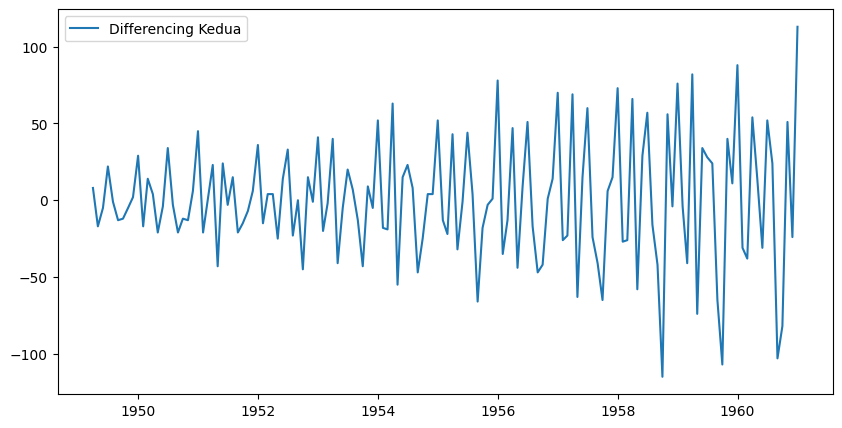

ADF Statistic:  -16.384231542468516
p-value:  2.7328918500141235e-29
Critical Values:  {'1%': np.float64(-3.4816817173418295), '5%': np.float64(-2.8840418343195267), '10%': np.float64(-2.578770059171598)}


In [12]:
# differencing ke 2
df_diff2 = df_diff.diff().dropna()

# plot hasil differencing ke 2
plt.figure(figsize = (10, 5))
plt.plot(df_diff2, label = "Differencing Kedua")
plt.legend()
plt.show()

# Uji ADF setelah differencing ke 2
adf_result2 = adfuller(df_diff2)

print("ADF Statistic: ", adf_result2[0])
print("p-value: ", adf_result2[1])
print("Critical Values: ", adf_result2[4])


```
differencing 2 tidak digunakan karena terlalu stasioner, p-value sangat kecil, ada resiko over differencing

# Plot ACF dan PACF

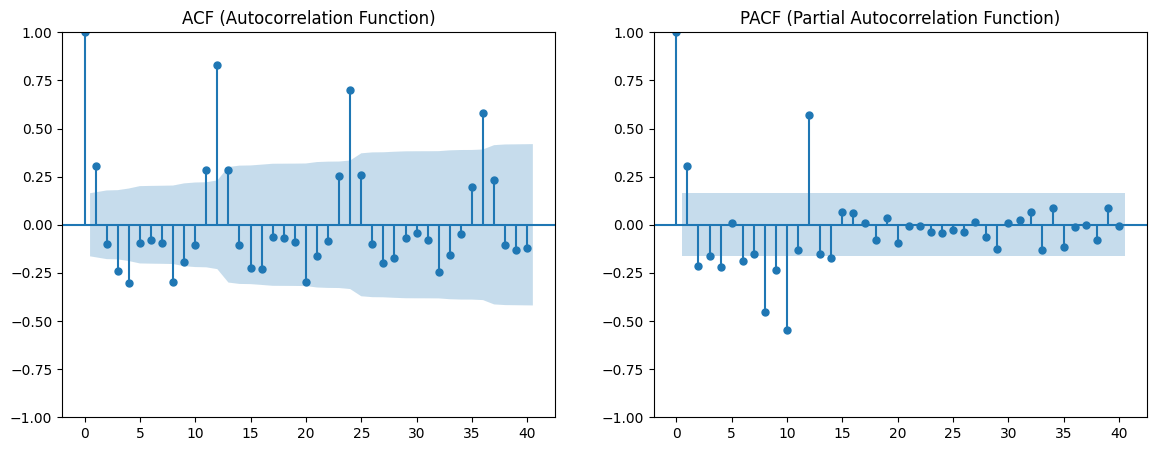

In [13]:
# Gunakan df_diff yang sudah ada
fig, axes = plt.subplots(1, 2, figsize=(14,5))

plot_acf(df_diff, ax=axes[0], lags=40)
axes[0].set_title("ACF (Autocorrelation Function)")

plot_pacf(df_diff, ax=axes[1], lags=40, method="ywm")
axes[1].set_title("PACF (Partial Autocorrelation Function)")

plt.show()


# Pemilihan Model Awal dengan Arima
```
Berdasarkan plot ACF dan PACF, nilai p dan 1 adalah (p=1, 1=0 atau 1). Oleh karena itu, saya akan melakukan pengujian beberapa model Arima (1,1,0), (1,1,1), (2,1,0), dan (2,1,1). Model dengan nilai AIC/BIC terkecil nanti akan dipilih sebagai model terbaik.
```

In [14]:
candidates = [(1,1,0), (1,1,1), (2,1,0), (2,1,1)]
results =[]
for order in candidates:
    model = ARIMA(df['Passengers'], order=order)
    res = model.fit()
    results.append({'order' : order, 'aic' : res.aic, 'bic' : res.bic, 'res' : res })

df_models = pd.DataFrame([{'order' : r['order'], 'aic' : r['aic'], 'bic' : r['bic']} for r in results])
df_models = df_models.sort_values('aic').reset_index(drop=True)
print(df_models)

       order          aic          bic
0  (2, 1, 1)  1378.338320  1390.189698
1  (1, 1, 1)  1394.682505  1403.571039
2  (2, 1, 0)  1396.587695  1405.476229
3  (1, 1, 0)  1401.852127  1407.777817


# Take best model

In [15]:
best = min(results, key=lambda x: x['aic'])
res = best['res']
print("Best order by AIC : ", best['order'])
print(res.summary())

Best order by AIC :  (2, 1, 1)
                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -685.169
Date:                Wed, 24 Sep 2025   AIC                           1378.338
Time:                        08:28:46   BIC                           1390.190
Sample:                    01-31-1949   HQIC                          1383.154
                         - 12-31-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0907      0.083     13.190      0.000       0.929       1.253
ar.L2         -0.4890      0.097     -5.046      0.000      -0.679      -0.299
ma.L1         -0.8439

```
Berdasarkan perbandingan AIC dan BIC dari beberapa kandidat model ARIMA, model ARIMA(2,1,1) dipilih karena memilikki nilai AIC dan BIC paling rendah/terkecil dibanding kandidat lain. Ini menandakan bahwa model ini memberikan keseimbagan terbaik antara goodnes of fit dan kompleksitas model.
```

# Diagnostic plots + Ljung-Box test

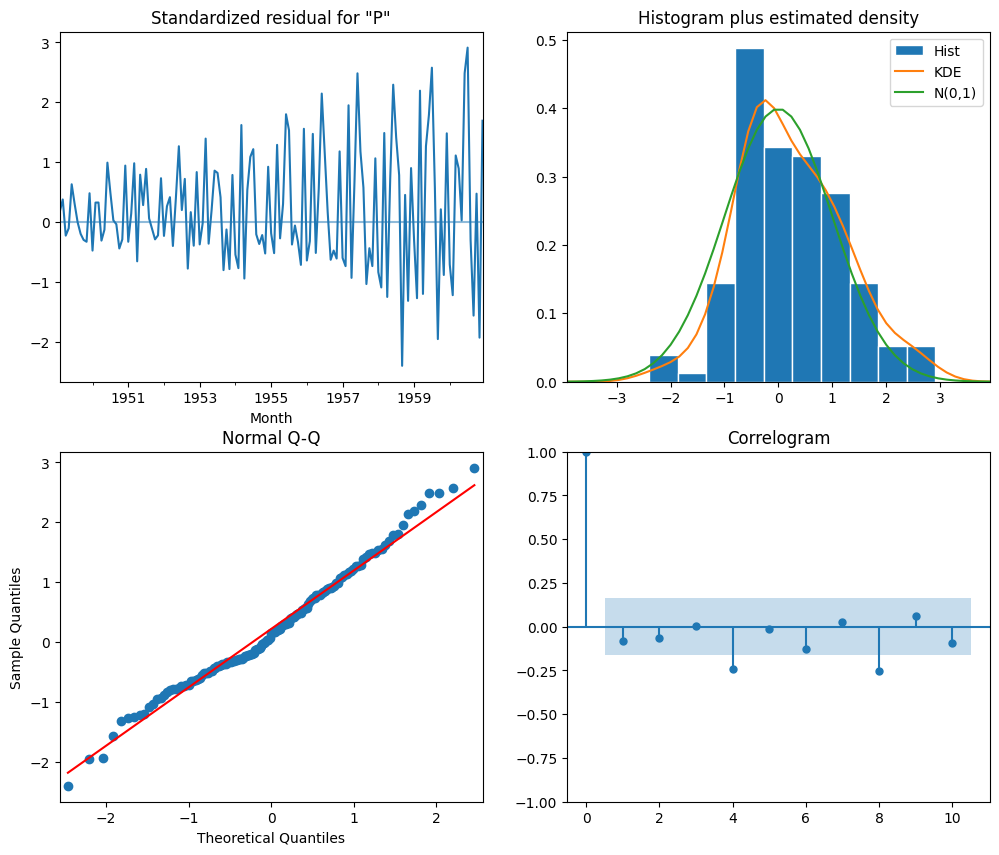


Ljung-Box test on residuals: 
       lb_stat     lb_pvalue
10   21.847917  1.589839e-02
15   99.661506  1.512353e-14
20  117.229978  9.268933e-16


In [18]:
res.plot_diagnostics(figsize=(12,10))
plt.show()

lb = acorr_ljungbox(res.resid, lags=[10, 15, 20], return_df=True)
print("\nLjung-Box test on residuals: ")
print(lb)


```
Diagnostics Plots Result
- Standardized Residuals: Residual terlihat  acak dan tidak membentuk pola tertentu. Namun terdapat fluktuasi cukup besar pada periode akhir (1959-1960).
- Histogram + KDE : Distribusi residual mendekati normal, meskipun terlihat agak miring ke kanan.
- Normal Q-Q Plot : Sebagian besar titik mengikuti garis lurus, menunjukan bahwa residu relatif normal. Penyimpangan terjadi hanya di bagian tail/ekor.
- Correlogram (ACF Residuals) : Hampir semua spike berada dalam batas kepercayaan, menandakan tidak ada autocorrelation yang kuat tersisa.

Ljung-Box Test Result
- Hasil Uji menunjukan p-value < 0.05 pada lag 10, 15 dan 20.
- artinya H0 ditolak, masih terdapat autocorrelation signifikan dalam residuals.

Kesimpulan 
- ARIMA(2,1,1) adalah model terbaik di antara kandidat non-seasonal ARIMA.  
- Namun, karena residual masih mengandung autocorrelation, model ini belum sepenuhnya menangkap pola data.  
- Hal ini sesuai dengan ekspektasi, karena dataset AirPassengers memiliki pola musiman yang kuat (seasonality tahunan, m=12).  
- Oleh karena itu, langkah berikutnya adalah menguji SARIMA untuk menangani komponen musiman.

# SARIMA

In [21]:
sarima_candidates =[(1,1,0,12), (1,1,1,12)]

sarima_results = []
for so in sarima_candidates:
    model_s = SARIMAX(df['Passengers'],
                    order=(2,1,1),
                    seasonal_order=so,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    res_s = model_s.fit(disp=False)
    sarima_results.append({
        'seasonal_order' : so,
        'aic' : res_s.aic,
        'bic' : res_s.bic,
        'res' : res_s
    })

df_sar = pd.DataFrame([{
    'seasonal_order' : r['seasonal_order'],
    'aic' : r['aic'],
    'bic' : r['bic']
}
for r in sarima_results])

print("\nSarima Candidates: ")
print(df_sar.sort_values('aic').reset_index(drop=True))


Sarima Candidates: 
  seasonal_order         aic         bic
0  (1, 1, 0, 12)  923.849081  937.659951
1  (1, 1, 1, 12)  924.314372  940.887416


```
#### Kesimpulan
- Model **SARIMA(2,1,1)(1,1,0,12)** memiliki nilai AIC dan BIC paling rendah, sehingga dipilih sebagai model terbaik.  
- Perbandingan dengan ARIMA non-seasonal menunjukkan perbaikan yang sangat signifikan (AIC turun dari 1378 → 923).  
- Hal ini membuktikan bahwa memasukkan komponen musiman (seasonal order) sangat penting untuk memodelkan dataset *AirPassengers*.  

Langkah selanjutnya adalah melakukan evaluasi residual pada model SARIMA terbaik untuk memastikan asumsi white noise terpenuhi.

# Diagnostic & residuals test

Best SARIMA order:  (1, 1, 0, 12)
                                      SARIMAX Results                                      
Dep. Variable:                          Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 1)x(1, 1, [], 12)   Log Likelihood                -456.925
Date:                             Wed, 24 Sep 2025   AIC                            923.849
Time:                                     09:13:01   BIC                            937.660
Sample:                                 01-31-1949   HQIC                           929.456
                                      - 12-31-1960                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3003      0.088     -3.395      0.001      -0.474      

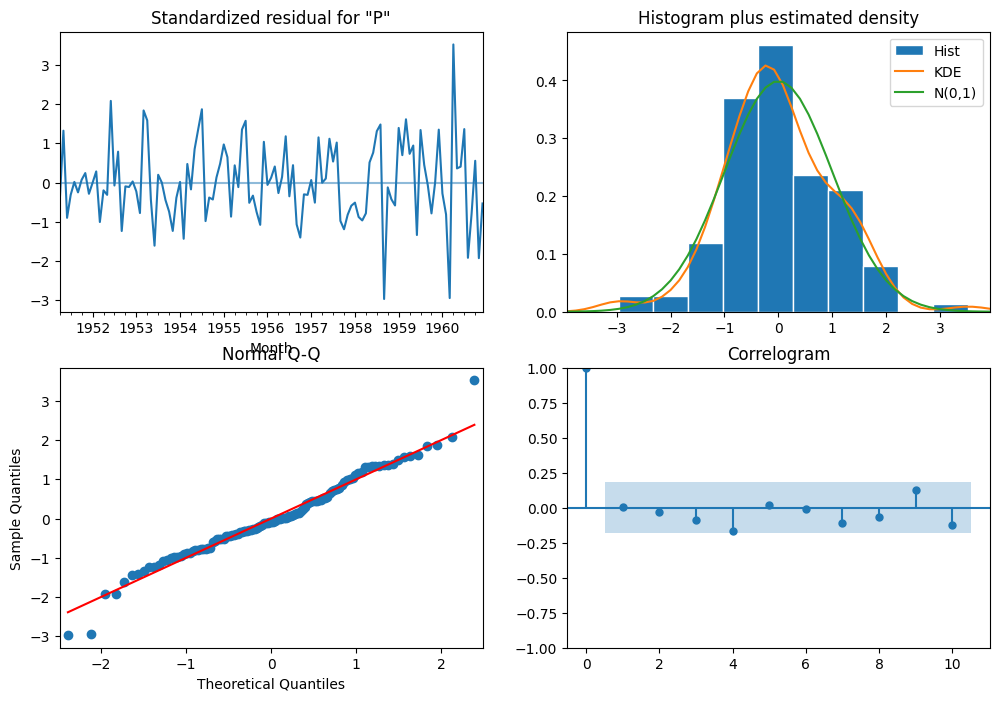


LjungBox test on SARIMA residuals: 
      lb_stat  lb_pvalue
10   6.650530   0.757974
15  12.126274   0.669447
20  16.377913   0.692920


In [24]:
# ambil model terbaik SARIMA
best_sarima = min(sarima_results, key=lambda x: x['aic'])
res_sarima = best_sarima['res']
print("Best SARIMA order: ", best_sarima['seasonal_order'])
print(res_sarima.summary())

#diagnostic plots
res_sarima.plot_diagnostics(figsize=(12,8))
plt.show()

#ljung-box test
lb_sar = acorr_ljungbox(res_sarima.resid, lags=[10,15,20], return_df=True)
print("\nLjungBox test on SARIMA residuals: ")
print(lb_sar)

Insight
- Standardized Residuals: Terlihat acak tidak ada trend atau pola tertentu bertanda bagus.

- Histogram + KDE: Distribusi residual mendekati normal standar (0,1), walaupun sedikit lebih tebal di tail kanan.

- Q-Q PlOT: Hampir semua titik mengikuti garis yang berarti resiudal relatif normal, walaupun ada sedikit penyimpangan di ujung tail.

- Correlogram: Semua spike berada dalam batas kepercayaan dan tidak ada autocorrelation signifikan tersisa. 

- Model SARIMA(2,1,1),(1,1,0,12) jauh lebih baik dibanding ARIMA non-seasonal (AIC turun drastis dari 1378 → 923).

- Residual sudah acak (white noise) model valid.

- Model siap dipakai untuk forecasting jumlah penumpang pesawat di tahun berikutnya.

# Forecasting Model SARIMA terbaik

```
Setelah didapatkan model terbaik yang terbukti valid, langkah selanjutnya saya akan melakukan forecasting jumlah penumpang pesawat.

Forecast akan dilakukan untuk period 24 bulan atau 2 Tahun kedepan. Hasil akan divisualisasikan dengan data historis agar terlihat perbandingan antara data aktual dan hasil prediksi.



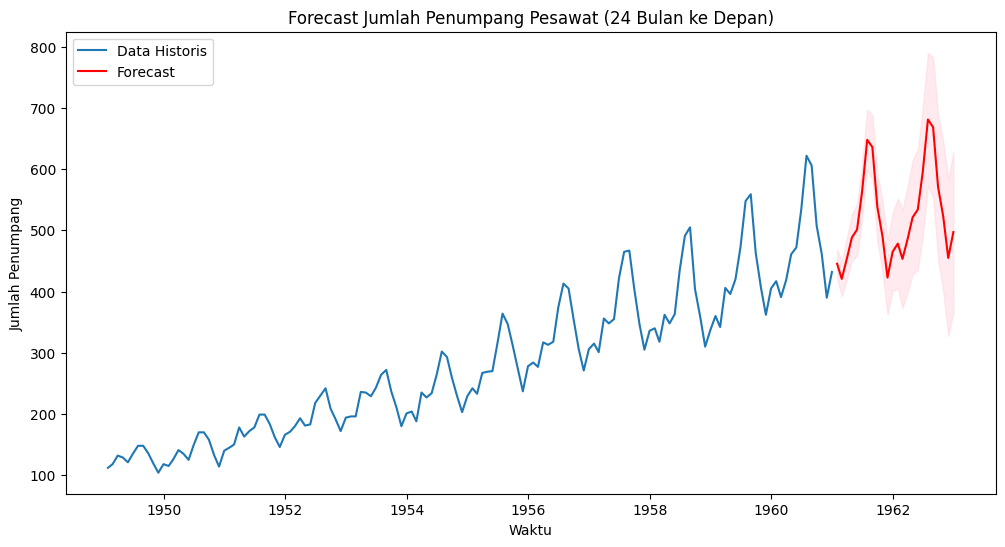

In [26]:
# Forecasting 24 bulan ke depan
steps = 24
forecast_res = res_sarima.get_forecast(steps=steps)

# Prediksi dan interval kepercayaan
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

# Plot data historis + forecast
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Passengers'], label="Data Historis")
plt.plot(forecast_mean.index, forecast_mean, label="Forecast", color="red")

# plot confidence interval
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color="pink", alpha=0.3)

plt.title("Forecast Jumlah Penumpang Pesawat (24 Bulan ke Depan)")
plt.xlabel("Waktu")
plt.ylabel("Jumlah Penumpang")
plt.legend()
plt.show()




Hasil Visualisasi:
- Garis Biru menandakan data historis jumlah penumpang dari tahun 1949 - 1960.
- Garis Merah menandakan hasil prediksi jumlah penumpang pesawat untuk periode 2 tahun berikutnya.
- Area Merah Muda menandakan interval kepercayaan 95%, menunjukan ketidakpastian hasil prediksi.


Insight:
- Forecast menunjukan tren jumlah penumpang terus meningkat dengan pola musiman yang konsisten.
- model mampu menangkap pola seasonality dengan baik, terlihat dari gelombang prediksi yang cukup mirip dengan data historis yang ada.
- Interval kepercayaan semakin meleber ke depan mencerminkan meningkatnya ketidakpastian prediksi jangka panjang.

Model SARIMA yang digunakan berhasil menghasilkan prediksi yang cukup realistis serta konsisten dengan pola data historis.

Forecast ini dapat digunakan untuk mendukung pengambilan keputusan seperti :
- Perencanaan kapasitas penerbangan.
- Strategi pemasaran berdasarkan period high season vs low season.
- Perencanaan infrastruktur bandara untuk jangka panjang.

# Kesimpulan

Pada project ini, dilakukan analisis deret waktu (*time series analysis*) terhadap dataset **AirPassengers** (jumlah penumpang pesawat bulanan periode 1949–1960).  
Proses analisis mengikuti tahapan sistematis sesuai pedoman pembelajaran:

### 1. Eksplorasi Awal
- Data menunjukkan adanya **tren naik jangka panjang** dan **pola musiman tahunan** yang jelas.  
- Hal ini mengindikasikan bahwa data tidak stasioner.

### 2. Uji Stasioneritas
- Augmented Dickey-Fuller (ADF Test) pada data asli → p-value sangat tinggi (tidak stasioner).  
- Setelah differencing pertama (d=1) → p-value ~0.05 (borderline stasioner).  
- Diputuskan menggunakan **d=1**.

### 3. Identifikasi Model
- Plot **ACF & PACF** menunjukkan kandidat model dengan p kecil dan q kecil.  
- Dicoba beberapa kandidat ARIMA: (1,1,0), (1,1,1), (2,1,0), (2,1,1).  
- Hasil AIC/BIC → **ARIMA(2,1,1)** terbaik di antara kandidat non-seasonal.

### 4. Evaluasi Residual ARIMA
- Diagnostic plots ARIMA(2,1,1) menunjukkan residual cukup acak, namun Ljung-Box Test masih signifikan → masih ada autocorrelation tersisa.  
- Artinya ARIMA non-seasonal belum cukup baik.

### 5. Model SARIMA
- Karena terdapat pola musiman, diuji model **SARIMA(2,1,1)(P,D,Q,12)**.  
- Kandidat yang dicoba: (1,1,0,12) dan (1,1,1,12).  
- Hasil: **SARIMA(2,1,1)(1,1,0,12)** memiliki AIC/BIC terendah (923.85 / 937.66).  
- Diagnostic plots dan Ljung-Box Test menunjukkan residual sudah menyerupai white noise.  
- Dengan demikian, model ini dipilih sebagai **model final**.

### 6. Forecasting
- Forecast dilakukan untuk **24 bulan ke depan (1961–1962)**.  
- Hasil prediksi konsisten dengan tren historis: jumlah penumpang terus meningkat dengan pola musiman tahunan.  
- Interval kepercayaan semakin melebar ke depan, mencerminkan ketidakpastian prediksi jangka panjang.

---

### Kesimpulan Utama
- Model terbaik untuk dataset ini adalah **SARIMA(2,1,1)(1,1,0,12)**.  
- Model berhasil menangkap **tren jangka panjang** dan **seasonality tahunan** dengan baik.  
- Forecast dapat dimanfaatkan untuk mendukung **perencanaan kapasitas penerbangan, strategi pemasaran, dan pengembangan infrastruktur**.  

Project ini menunjukkan alur lengkap analisis deret waktu, mulai dari eksplorasi data, uji stasioneritas, pemilihan model, evaluasi residual, hingga forecasting.
